# Evenements culturels : Création d'une carte interactive

Durant ce projet, nous allons utiliser la base de données répertoriant les évènements culturels en île de France (https://data.iledefrance.fr/explore/dataset/evenements-publics-cibul/table/) pour extraire les différents évènements et récupérer les informations importantes comme la date, le prix, ou le sujet et les mettre sous des formes faciles à utiliser.

Tout d'abord, nous allons import le dataframe et récupérer les informations que nous pouvons principalement grâce à des expressions régulières et à du web scraping. Ensuite, pour obtenir le sujet des évènements nous allons utiliser du NLP en trouvant les termes revenant le plus souvent. Finalement, nous finirons par analyser les données trouvées.

from datetime import time## Installations et imports de modules

In [1]:
# Trivia
import pandas as pd
import numpy as np
from collections import Counter

# Regex
import re

# API, data import
import urllib
import bs4
from urllib import request
import requests

# User informations
import sys
!{sys.executable} -m pip install geopy
import geopy
from geopy.geocoders import Nominatim
from geopy import distance
import datetime as dt

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re

# Natural Language Processing
!pip install nltk
import nltk
from nltk.corpus import stopwords
from time import time
#from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
!pip install pywaffle
from pywaffle import Waffle
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

!pip install spacy
!pip install https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.1.0/fr_core_news_sm-3.1.0.tar.gz

import spacy

nlp = spacy.load("fr_core_news_sm")

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  Using cached https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.1.0/fr_core_news_sm-3.1.0.tar.gz (17.1 MB)
  Preparing metadata (setup.py) ... done


## Données : Collecte et Nettoyage

In [2]:
class User:
    ''' The User Class allows us to store every piece of information about the User '''
    
    def __init__(self, address, date, price_max = 42):
        geolocator = Nominatim(user_agent="CulturalEvents")
        location = geolocator.geocode(address)
        self.latlon = (location.latitude, location.longitude)
        self.date = date
        self.price_max = price_max
        
Naclanga = User("27 Boulevard Thomas Gobert, Palaiseau", dt.date.today())

In [3]:
# Query to extract a specific frame of time, the user desired date
query = "date_start < " + str(Naclanga.date + dt.timedelta(days=7)) + " AND date_start > "  + str(Naclanga.date)

# Request. We can extract up to 1000 rows but it can be time consuming, that's why we restrict the timeframe
url = "https://data.iledefrance.fr/api/records/1.0/search/?dataset=evenements-publics-cibul&q=&rows=1000&q=(" + query + ")&sort=date_start"
req = requests.get(url)
df = pd.json_normalize(req.json()['records'])

# Rename the columns
important_keys = ["fields.title", "fields.latlon", "fields.date_start", "fields.tags", "fields.pricing_info", "fields.description",'fields.link', 'fields.free_text', 'fields.address', 'fields.department','fields.placename', 'fields.region', 'fields.date_end', 'fields.lang', 'geometry.type', 'geometry.coordinates', 'fields.city_district']
df = df[important_keys]
dict_important_keys = {elt : elt.replace("fields.", "") for elt in important_keys}
df.rename(columns = dict_important_keys, inplace=True)

df_to_treat = df.copy()
df_to_treat

,title,latlon,date_start,tags,pricing_info,description,link,free_text,address,department,placename,region,date_end,lang,geometry.type,geometry.coordinates,city_district
0,Spectacle : Qui est Monsieur Schmitt ?,"[48.822957, 2.269862]",2022-01-12,"Stéphane De Groodt,Valérie Bonneton,Sébastien ...",https://www.palaisdescongresdissy.com/fr/site/...,Stéphane De Groodt et Valérie Bonneton dans la...,http://openagenda.com/event/spectacle-qui-est-...,M. et Mme Bélier dînent tranquillement dans le...,"25 avenue Victor Cresson, 92130 Issy-les-Mouli...",Hauts-de-Seine,Palais des Congrès d'Issy,Île-de-France,2022-01-12,fr,Point,"[2.269862, 48.822957]",NaN
1,Tous en scène 2,"[48.8258, 2.269464]",2022-01-12,NaN,NaN,Retrouvez ces animaux artistes dans leur nouve...,http://openagenda.com/event/tous-en-scene-2-37...,Si Buster et sa troupe ont fait du Nouveau Thé...,"11-13, rue Danton 92130 Issy-les-Moulineaux",Hauts-de-Seine,Ciné d'Issy,Île-de-France,2022-01-12,fr,Point,"[2.269464, 48.8258]",NaN
2,Cycle de formation sur le Missel et l’Eucharistie,"[48.882801, 2.312324]",2022-01-12,NaN,NaN,A l’occasion de la mise en vigueur de la nouve...,http://openagenda.com/event/cycle-de-formation...,Prochaine rencontre le mercredi 12 janvier à 2...,"22 bis rue Legendre, 75017 Paris",Paris,Église Saint-Charles de Monceau,Île-de-France,2022-01-12,fr,Point,"[2.312324, 48.882801]",NaN
3,Conté-Partagé,"[48.833004, 2.313716]",2022-01-12,NaN,NaN,Une séance de contes du monde pour les enfants...,http://openagenda.com/event/conte-partage,NaN,23 bis rue du Moulin de la Vierge,Paris,le moulin de la vierge,Île-de-France,2022-01-12,fr,Point,"[2.313716, 48.833004]",NaN
4,Cartographie sensible de Versailles,"[48.803948, 2.134068]",2022-01-12,NaN,Sur réservation,"Durant ces 4 ateliers, les enfants écriront pu...",http://openagenda.com/event/cartographie-sensi...,NaN,8 rue Saint-Simon 78000 Versailles,Yvelines,Atelier Numérique,Île-de-France,2022-02-02,fr,Point,"[2.134068, 48.803948]",Montreuil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,JOULE - installation vidéo,"[48.787452, 2.044525]",2022-01-07,NaN,Entrée libre,JOULE est un projet chorégraphique consacré à ...,http://openagenda.com/event/joule-installation...,JOULE est un **projet chorégraphique consacré ...,Saint-Quentin-en-Yvelines,Yvelines,"Théâtre,scène nationale de Saint-Quentin-en-Yv...",Île-de-France,2022-02-19,fr,Point,"[2.044525, 48.787452]",NaN
176,JOSEF JOSEF,"[48.875921, 2.097268]",2022-01-07,Concert,Plein tarif 25€ / Tarif réduit 16€,Concert,http://openagenda.com/event/josef-josef,### **Vendredi 7 janvier**\n\n### **à 20h30**\...,44 allée des épines 78160,Yvelines,Centre culturel Jean Vilar,Île-de-France,2022-01-07,fr,Point,"[2.097268, 48.875921]",NaN
177,Vive le Sport,"[48.890801, 2.375054]",2022-01-07,NaN,NaN,Atelier chansons avec l'association Mélodix,http://openagenda.com/event/vive-le-sport,NaN,"15 rue Mathis, 75019",Paris,Centre Paris Anim'Mathis,Île-de-France,2022-01-08,fr,Point,"[2.375054, 48.890801]",NaN
178,Théâtre - L'Avare,"[49.087273, 2.505562]",2022-01-07,"théâtre,l'avare,molière","9€ / 5,50€ / 2,80€",L'Avare de Molière / Mise en scène de Tigran M...,http://openagenda.com/event/theatre-lavare,**L'Avare**\n**Compagnie de L'Illustre Théâtre...,rue marcel petit 95670 Marly-la-Ville,Val-d'Oise,Espace Culturel Lucien Jean,Île-de-France,2022-01-07,fr,Point,"[2.505562, 49.087273]",Le Clos Maillard


### Calcul de la distance

Grâce aux informations contenues dans le tableau et celles fournies par l'utilisateur. On peut calculer la distance géographique entre l'évènement et l'adresse de l'utilisateur

In [4]:
df_to_treat['distance'] = df['latlon'].apply(lambda x: distance.distance(x, Naclanga.latlon).km)
df_to_treat['distance']

0      13.305249
1      13.585167
2      20.651215
3      15.803483
4      11.175823
         ...    
175    14.036875
176    19.592094
177    23.644691
178    47.319266
179    18.518427
Name: distance, Length: 180, dtype: float64

### Extraction du prix

Dans ce second cas les informations sont dans le tableau mais pas sous une forme très utile. Par conséquent on utilise les expressions régulières pour obtenir des prix en nombre

In [5]:
def extract_price_regex(x):
    ''' Returns an estimation of the price of the event '''
    
    # Multiple price can be there so we are going to find them all and compute the mean
    L = []
    for k in re.findall("\S+\s?€", str(x)):
        try:
            a = float(k.replace("€", "").replace(",", ".")) # Conversion

        # If there is no price or it doesn't work
        except ValueError:
            a = float("NaN")
        
        L.append(a)
        
    return np.mean(L)

df_to_treat['pricing_info'] = df['pricing_info'].apply(lambda x:extract_price_regex(x))

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [6]:
df_to_treat['pricing_info']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
175          NaN
176    20.500000
177          NaN
178     5.766667
179          NaN
Name: pricing_info, Length: 180, dtype: float64

### Extraction des horaires

Dans le troisième cas, l'information n'est pas dans le tableau mais on peut la trouver grâce au lien associé, d'où l'utilisation de webscraping.

In [7]:
def get_text(link):
    ''' Requests the html code of the page '''
    request_text = request.urlopen(link).read()
    page = bs4.BeautifulSoup(request_text)
    return(page)

def get_hours_regex(text):
    ''' Returns the hours of opening on the html page '''
    return str(text.select('span.hour')[0]).replace('<span class="hour">', "").replace("</span>", "")
    
def get_timespan(link):
    ''' Given a link, this function uses the last two to return the hours of opening '''

    try:
        text = get_text(link)
        hours = get_hours_regex(text).split('-')
        hours[0] = hours[0].replace(" ", "")
        hours[1] = hours[1].replace(" ", "")

    except (urllib.error.HTTPError, IndexError): # If the Event is not correctly setup (error 404) or the event is not accessible (error 403)
        hours = float("NaN")
        
    return hours

# Time consuming, so we should get all information at once to avoid doing too much webscraping
df_to_treat['opening_hours'] = df['link'].apply(lambda link: get_timespan(link))

# Should we differency ponctual events (movies, plays, sports) and long running events (expositions) ?
# -> We can probably do it judging the timespan of the events in terms of days and hours, but is it useful ?

In [8]:
df_to_treat['opening_hours']

0      [20:30, 22:00]
1      [14:30, 16:19]
2      [20:30, 22:00]
3      [14:00, 15:00]
4      [14:00, 16:00]
            ...      
175    [18:00, 22:00]
176    [20:30, 22:00]
177    [20:00, 22:00]
178    [20:30, 22:00]
179    [19:00, 20:00]
Name: opening_hours, Length: 180, dtype: object

In [9]:
def duration(t):
    ''' '''
    try:
        end = dt.datetime.combine(dt.date.fromisoformat(str(t['date_end'])), dt.time.fromisoformat(str(t['opening_hours'][1])))
        start = dt.datetime.combine(dt.date.fromisoformat(str(t['date_start'])), dt.time.fromisoformat(str(t['opening_hours'][0])))
    
        return end - start
    
    except TypeError:
        
        return float("NaN")

df_to_treat['duration'] = df_to_treat[['opening_hours','date_end', 'date_start']].apply(lambda x: duration(x), axis=1)
df_to_treat['duration']

0      0 days 01:30:00
1      0 days 01:49:00
2      0 days 01:30:00
3      0 days 01:00:00
4     21 days 02:00:00
            ...       
175   43 days 04:00:00
176    0 days 01:30:00
177    1 days 02:00:00
178    0 days 01:30:00
179    0 days 01:00:00
Name: duration, Length: 180, dtype: timedelta64[ns]

## Natural Language Processing

### Création de Labels

Nous allons chercher les mots les plus utilisés pour créer des labels. Ici, on utilise toute la base de données sans faire de requête pour avoir le maximum de données

In [10]:
database = pd.read_csv('events_database.zip', compression='zip', header=0, sep=';')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
database[['Description', 'Détails', 'Mots clés']].head(5)

,Description,Détails,Mots clés
0,Découvrir le poney dans un séjour multisports ...,L'UCPA propose ses vacances apprenantes : Un s...,"UCPA,sport,nature,SFJBOI31E,import-ucpa-20200630"
1,"Un séjour qui combine sport, collectivité et f...",Cette colo te permettra de découvrir les multi...,"jeux olympiques,sport,import-pep"
2,Le top de la glisse de la côte californienne,L'UCPA propose ses vacances apprenantes : Un s...,"UCPA,sport,nature,SFJPON34R,import-ucpa-20200630"
3,Compagnie AtmosphèreS - mise en scène : Sara V...,"Camille, Camille, Camille\n-------------------...","Camille Claudel,Rodin,Paul claudel,sculptrice,..."
4,Mise en scène par Agnès Braunschweig. Cie Pros...,Je reviens de la vérité de Charlotte Delbo. Mi...,"Résistance,Déportation,Deuxième guerre mondial..."


In [12]:
def NaN_to_String(dataframe):
    ''' Convert the NaN value to Empty String and returns a cleaner text '''
    df_temp = dataframe.copy()
    df_temp[df_temp.isna()] = ""
    return df_temp.apply(lambda s: s.replace("\n", "").replace("\r", "") + ". ")

# Variable containing every piece of possibly useful text in the database
text_desc = (NaN_to_String(database['Description']) + NaN_to_String(database['Détails']) + NaN_to_String(database['Mots clés']).apply(lambda s: s.replace(",", ", ")))
text_desc

0         Découvrir le poney dans un séjour multisports ...
1         Un séjour qui combine sport, collectivité et f...
2         Le top de la glisse de la côte californienne. ...
3         Compagnie AtmosphèreS - mise en scène : Sara V...
4         Mise en scène par Agnès Braunschweig. Cie Pros...
                                ...                        
142884    Théâtre - Conférence / À partir de 14 ans   Pe...
142885    J'AI DES DOUTES. Molière 2019 du Comédien dans...
142886    Jazz vocal      Une formation alliant l’esprit...
142887    Théâtre   « Femme, réveille-toi » disait Olymp...
142888    CATCH D'IMPRO Encadrés par un arbitre qui s’oc...
Length: 142889, dtype: object

Premier test

On cherche les mots les plus utilisés grâce au module nltk en enlevant les mots qui ne sont pas composés de caractère alphabétique et les mots les plus usités en français (stop_words : le, la ...)

In [13]:
text = text_desc.head(100).sum().lower() # We use only 1000 rows but we can go higher, it just take more time
words = nltk.word_tokenize(text, language='french')
words = [word for word in words if word.isalpha()]
words = [w for w in words if not w in stop_words]
dic_words = Counter(words)

In [14]:
dic_words.most_common(20)

[('a', 55),
 ('https', 46),
 ('cette', 34),
 ('plus', 30),
 ('université', 30),
 ('the', 25),
 ('formation', 24),
 ('paris', 21),
 ('tout', 20),
 ('spectacle', 19),
 ('art', 19),
 ('cadre', 17),
 ('comment', 17),
 ('projet', 16),
 ('recherche', 15),
 ('of', 15),
 ('and', 15),
 ('atelier', 15),
 ('décembre', 15),
 ('séjour', 14)]

Comme on peut le voir beaucoup de mots ne correspondent pas à nos attentes, certains ne sont même pas des mots d'ailleurs.

Une idée serait d'utiliser une méthode d'étiquettage morpho syntaxique, ainsi on pourrait conserver seulement les noms communs. Pour cela il faut utiliser spacy plutôt que nltk car le français n'est pas supporté pour cette méthode dans nltk.

Second Test : L'étiquettage morpho-syntaxique

In [15]:
def return_POS(sentence, n = -1):
    ''' Returns a list of tags, there are the most used nouns in the database. n is the number of tags that we want. If n = -1, every possible tags are returned '''
    
    # Tokenize
    doc = nlp(sentence)
    
    # We only keep words being labellized as nouns
    words = [[X.lemma_, X.lemma_] for X in doc if (X.is_alpha == True and X.pos_ == "NOUN" and not(X in stop_words))]
    df_words = pd.DataFrame(words, columns=['tags', 'unique_tags'])
    
    if n == -1:
        return list(df_words.groupby(['unique_tags']).count().sort_values('tags', ascending=False).to_dict()['tags'].keys())
    else:
        return list(df_words.groupby(['unique_tags']).count().sort_values('tags', ascending=False).head(n).to_dict()['tags'].keys())

In [16]:
tags = return_POS(text_desc.head(1000).sum().lower(), 50)
tags

['musique',
 'atelier',
 'théâtre',
 'concert',
 'projet',
 'visite',
 'scène',
 'monde',
 'histoire',
 'année',
 'groupe',
 'samedi',
 'exposition',
 'jeu',
 'public',
 'enfant',
 'spectacle',
 'an',
 'place',
 'dimanche',
 'création',
 'rencontre',
 'conférence',
 'recherche',
 'association',
 'vie',
 'aide',
 'travers',
 'cadre',
 'découverte',
 'festival',
 'temps',
 'artiste',
 'maison',
 'formation',
 'œuvre',
 'danse',
 'siècle',
 'musée',
 'travail',
 'ville',
 'soirée',
 'journée',
 'heure',
 'université',
 'occasion',
 'programme',
 'chanson',
 'centre',
 'rue']

In [17]:
df_to_treat['text'] = (NaN_to_String(df['tags']) + NaN_to_String(df['title']) + NaN_to_String(df['description']) + NaN_to_String(df['free_text'])).apply(lambda s: s.replace(",", ", "))
df_to_treat['tags'] = df_to_treat['text'].apply(lambda x:return_POS(x.lower()))
df_to_treat['tags'] = df_to_treat['tags'].apply(lambda x: [k for k in x if k in tags])

In [18]:
df_to_treat['tags'] 

0                                     [spectacle, cadre]
1      [spectacle, scène, théâtre, musique, recherche...
2                       [formation, occasion, rencontre]
3                               [enfant, monde, théâtre]
4                               [atelier, enfant, ville]
                             ...                        
175                               [projet, danse, monde]
176    [concert, groupe, an, monde, public, théâtre, ...
177                               [association, chanson]
178              [théâtre, année, scène, maison, enfant]
179                                                   []
Name: tags, Length: 180, dtype: object

In [19]:
df_to_treat[df_to_treat['tags'].apply(lambda x:x==[])]

,title,latlon,date_start,tags,pricing_info,description,link,free_text,address,department,...,region,date_end,lang,geometry.type,geometry.coordinates,city_district,distance,opening_hours,duration,text
6,Le B-A BA de la micro-entreprise,"[48.787838, 2.050474]",2022-01-12,[],NaN,"Animé par Cédric Poirrier et Denis Delétoille,...",http://openagenda.com/event/le-b-a-ba-de-la-mi...,Vous souhaitez créer une entreprise individuel...,"3, avenue du centre guyancourt",Yvelines,...,Île-de-France,2022-01-12,fr,Point,"[2.050474, 48.787838]",NaN,13.712115,"[14:30, 15:30]",0 days 01:00:00,. Le B-A BA de la micro-entreprise. Animé par ...
24,Perfectionne ton exposé,"[48.898602, 2.47798]",2022-01-12,[],NaN,Viens découvrir des techniques et astuces pour...,http://openagenda.com/event/perfectionne-ton-e...,Tu es au collège ? Tu as un exposé à préparer ...,"23 Rue Roger Salengro, 93140 Bondy",NaN,...,NaN,2022-01-19,fr,Point,"[2.47798, 48.898602]",NaN,29.107223,"[14:30, 16:00]",7 days 01:30:00,. Perfectionne ton exposé. Viens découvrir des...
25,NaN,"[48.898602, 2.47798]",2022-01-12,[],NaN,NaN,http://openagenda.com/event/comptines-calines-...,NaN,"23 Rue Roger Salengro, 93140 Bondy",NaN,...,NaN,2022-01-15,fr,Point,"[2.47798, 48.898602]",NaN,29.107223,"[10:00, 10:30]",3 days 00:30:00,. . . .
43,LA FRAGMENTATION DE LA LOI ET L’OMNIPRÉSENCE D...,"[48.84834, 2.351983]",2022-01-11,[],NaN,Mardis des Bernardins.,http://openagenda.com/event/le-juge-createur-d...,Ce bouleversement a des conséquences multiples...,"20 Rue de Poissy, 75005 Paris, France",Paris,...,Île-de-France,2022-01-11,fr,Point,"[2.351983, 48.84834]",5e Arrondissement,18.805619,"[20:00, 22:00]",0 days 02:00:00,. LA FRAGMENTATION DE LA LOI ET L’OMNIPRÉSENCE...
64,L'HOMME VIT D'OFFRANDE : QUE SUIS-JE PRÊ,"[48.84834, 2.351983]",2022-01-10,[],NaN,Les réalités essentielles.,http://openagenda.com/event/lhomme-vit-doffran...,Informations\r\n\r\nhttps://www.collegedesbern...,"20 Rue de Poissy, 75005 Paris, France",Paris,...,Île-de-France,2022-01-10,fr,Point,"[2.351983, 48.84834]",5e Arrondissement,18.805619,"[20:00, 21:30]",0 days 01:30:00,. L'HOMME VIT D'OFFRANDE : QUE SUIS-JE PRÊ. Le...
67,Club de lecture,"[48.829127, 2.317717]",2022-01-10,[],NaN,"Pour tous les passionnés de littérature, les d...",http://openagenda.com/event/club-de-lecture-97...,"Pour tous les passionnés de littérature, les d...",51 rue de l'Abbé Carton 75014 Paris,Paris,...,Île-de-France,2022-06-13,fr,Point,"[2.317717, 48.829127]",Paris 14e Arrondissement,15.604271,"[19:00, 20:30]",154 days 01:30:00,"lecture, club, littérature. Club de lecture. P..."
80,Franco Fagioli : Mozart et Les Castrats,"[48.804425, 2.120285]",2022-01-09,[],NaN,Mozart et les Castrats,http://openagenda.com/event/franco-fagioli-moz...,Si la passion de Mozart pour les voix féminine...,Château de Versailles,Yvelines,...,Île-de-France,2022-01-09,fr,Point,"[2.120285, 48.804425]",Notre-Dame,11.688577,"[15:00, 17:00]",0 days 02:00:00,. Franco Fagioli : Mozart et Les Castrats. Moz...
87,NaN,"[48.529633, 2.292857]",2022-01-09,[],NaN,NaN,http://openagenda.com/event/les-itinerantes-co...,NaN,rue René Cassin 91510 Lardy,Essonne,...,Île-de-France,2022-01-09,fr,Point,"[2.292857, 48.529633]",NaN,21.538194,"[16:00, 17:30]",0 days 01:30:00,. . . .
99,Hl. Drei Königsgottesdienst,"[48.868801, 2.277584]",2022-01-09,[],NaN,Familiengottesdienst mit Sternsingern,http://openagenda.com/event/hl-drei-konigsgott...,NaN,"38 rue Spontini, Paris 16ème",Paris,...,Île-de-France,2022-01-09,fr,Point,"[2.277584, 48.868801]",NaN,18.274953,"[11:00, 12:00]",0 days 01:00:00,. Hl. Drei Königsgottesdienst. Familiengottesd...
100,Messe des familles,"[48.845708, 2.403524]",2022-01-09,[],NaN,Suivie de la première réunion de préparation à...,http://openagenda.com/event/messe-des-familles...,NaN,34 rue du Rendez-vous 75012 PARIS,Paris,...,Île-de-France,2022-01-09,fr,Point,"[2.403524, 48.845708]",NaN,21.087086,"[10:00, 11:00]",0 days 01:00:00,. Messe des familles. Suivie de la première ré...


## Visualisation

<AxesSubplot:>

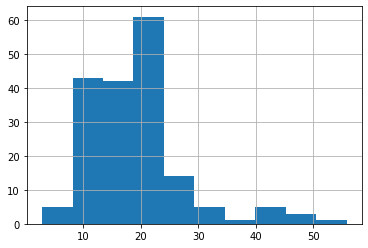

In [20]:
df_to_treat['distance'].hist()

In [21]:
#df_to_treat['distance'].hist()

<AxesSubplot:xlabel='duration'>

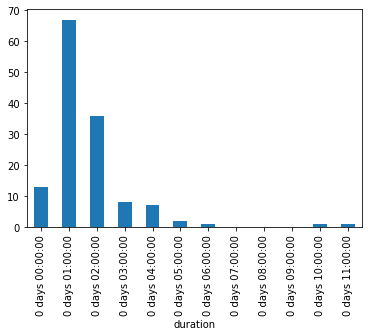

In [22]:
df_to_treat.reset_index()[df_to_treat["duration"].apply(lambda s:s >= dt.timedelta(days = 0) and s <= dt.timedelta(days = 1))].groupby(pd.Grouper(key="duration", freq='H'))['index'].count().plot(kind="bar")

138


<AxesSubplot:xlabel='duration'>

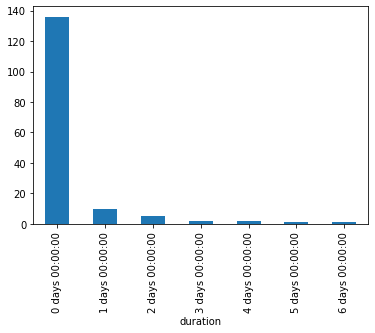

In [23]:
print(len(df_to_treat[df_to_treat["date_start"] == df_to_treat["date_end"]]))
df_to_treat.reset_index()[df_to_treat["duration"].apply(lambda s:s >= dt.timedelta(days = 0) and s <= dt.timedelta(days = 7))].groupby(pd.Grouper(key="duration", freq='D'))['index'].count().plot(kind="bar")

50


<AxesSubplot:>

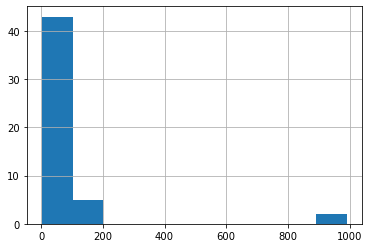

In [24]:
print(len(df_to_treat[df_to_treat['pricing_info'].notna()]))
df_to_treat['pricing_info'].hist()

In [36]:
def df_tags(tag):
    return df_to_treat[df_to_treat['tags'].apply(lambda s:tag in s)]

In [38]:
df_tags(['théâtre','enfant'])

,title,latlon,date_start,tags,pricing_info,description,link,free_text,address,department,...,region,date_end,lang,geometry.type,geometry.coordinates,city_district,distance,opening_hours,duration,text
